## Libs

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import copy
import os
from tqdm import tqdm

from torchvision.datasets import ImageFolder
from torch.nn import Module, Dropout2d, Flatten
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax, BatchNorm2d
from torch import flatten
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import max_pool2d, dropout
from torch.utils.data import TensorDataset



from torchvision import models
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import sys
import warnings
import cv2

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


## Stage 1. Model training.

#### Dataset reading and preparing

In [ ]:
dataset_path = "drive/MyDrive/Dataset"
os.listdir(dataset_path)

['training', 'validation']

In [ ]:
train_dataset = ImageFolder(dataset_path + '/training', transform=T.Compose([T.ToTensor(), T.Resize(256), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_dataset = ImageFolder(dataset_path + '/validation', transform=T.Compose([T.ToTensor(), T.Resize(256), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2)

#### Functions for visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Tiger (1)


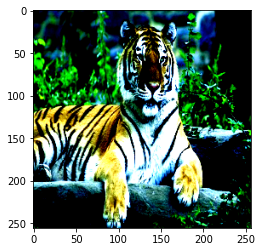

In [ ]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*train_dataset[1000])

def showInRow(list_of_images, titles = None):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    subplot.imshow(img.permute(1, 2, 0))
  plt.show()

#### Model 

In [ ]:
torch.manual_seed(43)

In [ ]:
class CustomCNN(nn.Module):
  def __init__(self, numChannels, classes):

    super(CustomCNN, self).__init__()

    self.dropout = nn.Dropout(0.2)
  
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=32, kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.conv1_bn = nn.BatchNorm2d(32)

    self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.conv2_bn = nn.BatchNorm2d(64)


    self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
    self.relu3 = ReLU()
    self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.conv3_bn = nn.BatchNorm2d(128)


    self.fc1 = Linear(in_features=107648, out_features=1000)
    self.relu3 = ReLU()
    self.fc2 = Linear(in_features=1000, out_features=classes)

  def forward(self, x):

    x = self.conv1(x)
    x = self.conv1_bn(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.conv2_bn(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = self.conv3(x)
    x = self.conv3_bn(x)
    x = self.relu3(x)
    x = self.maxpool3(x)
    x = self.dropout(x)

    x = flatten(x, 1)

    x = self.fc1(x)
    x = self.relu3(x)

    x = self.fc2(x)


    return x

#### Training Loop

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, scheduler=None, epochs=20, device="cuda"):
    best_loss = 1000
    best_model = copy.deepcopy(model)
    
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in tqdm(val_loader):
          with torch.no_grad():
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(output, dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        
        if scheduler != None:
          scheduler.step()
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

        if valid_loss < best_loss:
          best_model.load_state_dict(model.state_dict())
          best_loss = valid_loss
        
    return best_model

In [ ]:
model_2 = CustomCNN(3, 2).to("cuda")
lr = 1e-4
optimizer = optim.Adam(model_2.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
loss =  nn.CrossEntropyLoss()
best_model = train(model_2, optimizer, loss, train_loader, test_loader, epochs=10, device="cuda")


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 1, Training Loss: 1.57, Validation Loss: 0.77, accuracy = 0.71


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 2, Training Loss: 0.60, Validation Loss: 0.63, accuracy = 0.76


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 3, Training Loss: 0.24, Validation Loss: 0.31, accuracy = 0.85


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch: 4, Training Loss: 0.13, Validation Loss: 0.37, accuracy = 0.85


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 5, Training Loss: 0.08, Validation Loss: 0.43, accuracy = 0.81


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 6, Training Loss: 0.07, Validation Loss: 0.46, accuracy = 0.83


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch: 7, Training Loss: 0.09, Validation Loss: 0.47, accuracy = 0.84


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 8, Training Loss: 0.06, Validation Loss: 0.41, accuracy = 0.85


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch: 9, Training Loss: 0.12, Validation Loss: 0.53, accuracy = 0.84


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

Epoch: 10, Training Loss: 0.03, Validation Loss: 0.38, accuracy = 0.88


In [ ]:
torch.save(best_model.state_dict(), 'best_model.pt')

In [ ]:
best_model = CustomCNN(3, 2).to("cuda")
best_model.load_state_dict(torch.load("/content/best_model.pt"))

<All keys matched successfully>

#### Model asessment before attack

In [ ]:
def model_report(model, test_loader):
  preds = []
  targets = []
  valid_loss = 0.0
  loss_fn = nn.CrossEntropyLoss()

  for batch in tqdm(test_loader):
    with torch.no_grad():
      inputs, target = batch
      inputs, target = batch = inputs.to("cuda"), target.to("cuda")
      output = model(inputs)
      pred = torch.max(output, dim=1)[1]
      preds += pred.to("cpu")
      targets += target.to("cpu")
      loss = loss_fn(output, target) 
      valid_loss += loss.data.item() * inputs.size(0)

  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets))

model_report(model_2, test_loader)

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]



Validation loss is: 0.3775999677181244
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       110
           1       0.83      0.92      0.87        90

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



## Stage 2. Attack & Defence

In [ ]:
attack_set = [10, 11, 111, 112]
attack_dataset = torch.utils.data.Subset(test_dataset, attack_set)
attack_loader = DataLoader(attack_dataset, 1)

In [ ]:
def attack_output(model, attack_f, args):
  images = []
  preds = []
  for X, y in attack_loader:
    X, y = X.to("cuda"), y.to("cuda")
    delta = attack_f(model, loss, X, y, *args)
    altered_img = X.to("cuda")+delta
    pred = train_dataset.classes[torch.argmax(best_model(altered_img)).item()]

    images.append(altered_img.squeeze().to("cpu"))
    preds.append(pred)
    

  showInRow(images, preds)


def attacked_model_report(model, test_loader, attack_f, args):
  preds = []
  targets = []
  loss_fn = nn.CrossEntropyLoss()
  valid_loss = 0.0

  for (X, y) in tqdm(test_loader):
      X, y = X.to("cuda"), y.to("cuda")
      delta = attack_f(model, loss_fn, X, y, *args)
      output = model(X+delta)
      pred = torch.max(output, dim=1)[1]
      preds += list(pred.to("cpu"))
      targets += list(y.to("cpu"))
      loss = loss_fn(output, y)
      valid_loss += loss.data.item() * X.size(0)
  
  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets))
  

### Building attacks

FGSM

In [ ]:
def fgsm(model, loss_fn, X, y, e):
    delta = torch.zeros_like(X, requires_grad=True).to("cuda")
    loss = loss_fn(model(X + delta), y)
    loss.backward()
    g = delta.grad.detach()
    return e * g.sign()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


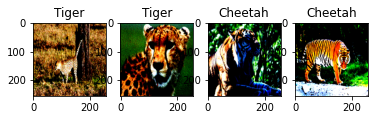

In [ ]:
args = [0.1]
attack_output(model_2, fgsm, args)

In [ ]:
attacked_model_report(model_2, test_loader, fgsm, args)

100%|██████████| 7/7 [00:03<00:00,  2.03it/s]



Validation loss is: 6.279686584472656
              precision    recall  f1-score   support

           0       0.23      0.26      0.24        88
           1       0.35      0.31      0.33       112

    accuracy                           0.29       200
   macro avg       0.29      0.29      0.29       200
weighted avg       0.30      0.29      0.29       200



PGD

In [ ]:
def pgd(model, loss_fn, X, y, e, alpha, num_iter, verbose=False):
    delta = torch.zeros_like(X, requires_grad=True).to("cuda")
    
    if verbose:
      iter_obj = tqdm(range(num_iter))
    else:
      iter_obj = range(num_iter)

    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0] * alpha * delta.grad.data).clamp(-e, e)
        delta.grad.zero_()
    return delta.detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


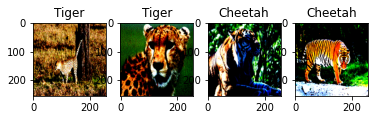

In [ ]:
args = [0.1, 1e4, 100]
attack_output(model_2, pgd, args)

In [ ]:
attacked_model_report(model_2, test_loader, pgd, args)

100%|██████████| 7/7 [02:44<00:00, 23.44s/it]



Validation loss is: 4.582411241531372
              precision    recall  f1-score   support

           0       0.12      0.13      0.12        95
           1       0.17      0.16      0.17       105

    accuracy                           0.14       200
   macro avg       0.15      0.14      0.14       200
weighted avg       0.15      0.14      0.15       200



C&W attack with $l_2$ norm

In [ ]:
# original paper: https://arxiv.org/pdf/1608.04644.pdf

def cw_l2(model, loss_fn, X, y, c, num_iter, lr):

  # f_1 functional from original paper
  def f(delta, X, y, model, loss_fn):
    return -loss_fn(model(X+delta), y)

  # Change of variables from original paper
  w = torch.zeros_like(X, requires_grad=True).to("cuda")
  
  optimizer = optim.Adam([w], lr=lr)
  loss_d = nn.MSELoss(reduction='sum')
  loss_f = torch.sum

  for i in range(num_iter):
    # Change of variables from original paper
    delta = 1/2 * (nn.Tanh()(w) + 1) - X
    
    # minimizing both negative loss of target and distance of attack
    overall_loss = loss_d(delta+X, X) + loss_f(c*f(delta, X, y, model, loss_fn))
    
    overall_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  
  return delta.detach()

Note: constant c was found by brute forcing instead of binary search like it was in original paper due to the lack of resources (colab contantly was taking gpu from 1.5 day of working)

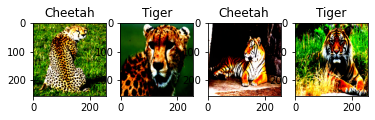

In [ ]:
args = [10, 100, 1e-1]
attack_output(model_2, cw_l2, args)

In [ ]:
attacked_model_report(model_2, test_loader, cw_l2, args)

100%|██████████| 7/7 [02:50<00:00, 24.29s/it]



Validation loss is: 0.7157291603088379
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        84
           1       0.75      0.65      0.69       116

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.68      0.67      0.67       200



C&W attack with $l_{1}$

In [ ]:
# original paper: https://arxiv.org/pdf/1608.04644.pdf

def cw_l_1(model, loss_fn, X, y, c, num_iter, lr):

  # f_1 functional from original paper
  def f(delta, X, y, model, loss_fn):
    return -loss_fn(model(X+delta), y)

  # Change of variables from original paper
  w = torch.zeros_like(X, requires_grad=True).to("cuda")
  
  optimizer = optim.Adam([w], lr=lr)
  loss_d = nn.MSELoss(reduction='sum')
  loss_f = torch.sum

  for i in range(num_iter):
    # Change of variables from original paper
    delta = 1/2 * (nn.Tanh()(w) + 1) - X
    
    # minimizing both negative loss of target and distance of attack
    overall_loss =  torch.norm(delta, 1) + loss_f(c*f(delta, X, y, model, loss_fn))
    overall_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  
  return delta.detach()

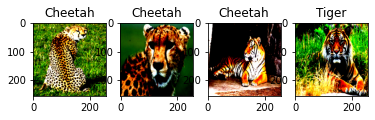

In [ ]:
args = [100, 500, 1e-1]
attack_output(model_2, cw_l_1, args)

In [ ]:
attacked_model_report(model_2, test_loader, cw_l_1, args)

100%|██████████| 7/7 [13:58<00:00, 119.79s/it]



Validation loss is: 0.7119308304786682
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        85
           1       0.75      0.65      0.70       115

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.69      0.68      0.68       200



As in the paper, my implemented cw with l_1 and l_inf norm attacks perform worse than l_2 

### Building defense

Adversarial training 

In [ ]:
# I do not want cuda out of memory warning, so I decreased batch size
train_loader = DataLoader(train_dataset, 8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, 8, num_workers=2)

Universal adversarial training function for all attacks

In [ ]:
def adversarial_train(model, optimizer, loss_fn, train_loader, val_loader, attack_f, args, 
                      scheduler=None, epochs=20, device="cuda"):
    best_loss = 1000
    best_model = copy.deepcopy(model)
    
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            delta = attack_f(model, loss_fn, inputs, targets, *args)
            output = model(inputs+delta)

            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in tqdm(val_loader):
          #with torch.no_grad():
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            delta = attack_f(model, loss_fn, inputs, targets, *args)

            output = model(inputs+delta)
            loss = loss_fn(output, targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(output, dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        
        if scheduler != None:
          scheduler.step()
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

        if valid_loss < best_loss:
          best_model.load_state_dict(model.state_dict())
          best_loss = valid_loss
        
    return best_model

Adversarial training for fgsm attack

In [ ]:
model_2_adv = CustomCNN(3, 2).to("cuda")
args = [0.1]
lr_2_adv = 1e-3
optimizer_2_adv = optim.Adam(model_2_adv.parameters(), lr=lr_2_adv)
scheduler_2_adv = StepLR(optimizer_2_adv, step_size=15, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_adv_model = adversarial_train(model_2_adv, optimizer_2_adv, loss, train_loader, test_loader, fgsm, args, scheduler=scheduler_2_adv, epochs=30, device="cuda")

100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Epoch: 1, Training Loss: 2.69, Validation Loss: 0.70, accuracy = 0.43


100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


Epoch: 2, Training Loss: 0.71, Validation Loss: 0.71, accuracy = 0.53


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch: 3, Training Loss: 0.71, Validation Loss: 0.73, accuracy = 0.52


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch: 4, Training Loss: 0.72, Validation Loss: 0.71, accuracy = 0.54


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Epoch: 5, Training Loss: 0.72, Validation Loss: 0.71, accuracy = 0.48


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch: 6, Training Loss: 0.72, Validation Loss: 0.86, accuracy = 0.54


100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


Epoch: 7, Training Loss: 0.71, Validation Loss: 0.81, accuracy = 0.55


100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Epoch: 8, Training Loss: 0.70, Validation Loss: 0.73, accuracy = 0.53


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch: 9, Training Loss: 0.68, Validation Loss: 0.76, accuracy = 0.58


100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Epoch: 10, Training Loss: 0.66, Validation Loss: 0.83, accuracy = 0.58


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Epoch: 11, Training Loss: 0.65, Validation Loss: 0.99, accuracy = 0.57


100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Epoch: 12, Training Loss: 0.63, Validation Loss: 0.75, accuracy = 0.66


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Epoch: 13, Training Loss: 0.60, Validation Loss: 0.71, accuracy = 0.68


100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


Epoch: 14, Training Loss: 0.58, Validation Loss: 0.68, accuracy = 0.65


100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


Epoch: 15, Training Loss: 0.56, Validation Loss: 0.73, accuracy = 0.63


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Epoch: 16, Training Loss: 0.46, Validation Loss: 0.76, accuracy = 0.67


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Epoch: 17, Training Loss: 0.45, Validation Loss: 0.67, accuracy = 0.70


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch: 18, Training Loss: 0.44, Validation Loss: 0.67, accuracy = 0.69


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch: 19, Training Loss: 0.42, Validation Loss: 0.71, accuracy = 0.69


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Epoch: 20, Training Loss: 0.42, Validation Loss: 0.68, accuracy = 0.71


100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Epoch: 21, Training Loss: 0.41, Validation Loss: 0.69, accuracy = 0.69


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Epoch: 22, Training Loss: 0.39, Validation Loss: 0.68, accuracy = 0.71


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch: 23, Training Loss: 0.39, Validation Loss: 0.65, accuracy = 0.72


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Epoch: 24, Training Loss: 0.39, Validation Loss: 0.69, accuracy = 0.73


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch: 25, Training Loss: 0.38, Validation Loss: 0.68, accuracy = 0.69


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Epoch: 26, Training Loss: 0.37, Validation Loss: 0.68, accuracy = 0.72


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Epoch: 27, Training Loss: 0.34, Validation Loss: 0.70, accuracy = 0.72


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Epoch: 28, Training Loss: 0.38, Validation Loss: 0.72, accuracy = 0.72


100%|██████████| 25/25 [00:03<00:00,  6.25it/s]


Epoch: 29, Training Loss: 0.35, Validation Loss: 0.72, accuracy = 0.71


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]

Epoch: 30, Training Loss: 0.31, Validation Loss: 0.73, accuracy = 0.72


In [ ]:
torch.save(best_adv_model.state_dict(), 'best_adv_model.pt')
best_adv_model = CustomCNN(3, 2).to("cuda")
best_adv_model.load_state_dict(torch.load("/content/best_adv_model.pt"))

<All keys matched successfully>

### Model asessmemnt after attack

Metrics are not so good, but much better than instantly after attack applying

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


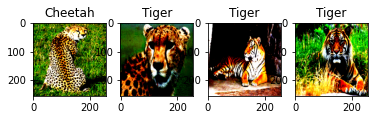

100%|██████████| 25/25 [00:04<00:00,  6.03it/s]



Validation loss is: 1.1910822820663451
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       104
           1       0.55      0.57      0.56        96

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200



In [ ]:
args = [0.1]
attack_output(best_adv_model, fgsm, args)
attacked_model_report(best_adv_model, test_loader, fgsm, args)

Adversarial training for pgd attack

In [ ]:
# it run for 4 hours and failed due to the limit of colab gpus
model_2 = CustomCNN(3, 2).to("cuda")
args = [0.1, 1e4, 100]
lr = 1e-3
optimizer = optim.Adam(model_2.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
loss =  nn.CrossEntropyLoss()
best_adv_model = adversarial_train(model_2, optimizer, loss, train_loader, test_loader, pgd, args, epochs=10, device="cuda")

torch.save(best_adv_model.state_dict(), 'best_adv_model.pt')
best_adv_model = CustomCNN(3, 2).to("cuda")
best_adv_model.load_state_dict(torch.load("/content/best_adv_model.pt"))

args = [0.1, 1e5, 10]
attack_output(best_adv_model, fgsm, args)
attacked_model_report(best_adv_model, test_loader, fgsm, args)

## Stage 3. Adaptive attack implementation

Adversarial Retraining implementation 

Both approaches from original paper - https://arxiv.org/pdf/1705.07263.pdf

However, due to the lack of resources, I implemented attacks and defense using fgsm. Nevertheless, the same code could be uses with any (pgd/c&w attack).

 My experiments proved the fact that fgsm is not effective for attacking adversarial retrained model.

In [ ]:
def generate_adversarial_samples(model, loader, attack_f, args):
  images = []
  for (X, y) in tqdm(loader):
    X, y = X.to("cuda"), y.to("cuda")
    delta = attack_f(model, loss, X, y, *args)
    altered_img = X.to("cuda")+delta

    images.append(altered_img.to("cpu"))    
  return images 

### Zero-Knowledge Attack Evaluation

#### Approach woth $F_{base}$ and $F_{secure}$

In [ ]:
args = [0.1]
loss = nn.CrossEntropyLoss()
train_adv_tensors = generate_adversarial_samples(best_model, train_loader, fgsm, args)
test_adv_tensors = generate_adversarial_samples(best_model, test_loader, fgsm, args)

adv_data_train = TensorDataset(torch.cat(train_adv_tensors), 
                               torch.tensor([2 for i in range(len(torch.cat(train_adv_tensors)))]))
adv_data_test = TensorDataset(torch.cat(test_adv_tensors),
                              torch.tensor([2 for i in range(len(torch.cat(test_adv_tensors)))]))

100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


In [ ]:
def collate(batch):
    
    # item: a tuple of (img, label)
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    data = torch.stack(data)
    target = torch.LongTensor(target)
    return [data, target]

In [ ]:
train_adv_dataset = torch.utils.data.ConcatDataset([adv_data_train, train_dataset])
test_adv_dataset = torch.utils.data.ConcatDataset([adv_data_test, test_dataset])

train_adv_loader = DataLoader(train_adv_dataset, 8, shuffle=True, collate_fn=collate, num_workers=2)
test_adv_loader = DataLoader(test_adv_dataset, 8, collate_fn=collate, num_workers=2)

In [ ]:
model_3 = CustomCNN(3, 3).to("cuda")
lr_3 = 1e-4
optimizer_3 = optim.Adam(model_3.parameters(), lr=lr_3)
scheduler_3 = StepLR(optimizer_3, step_size=5, gamma=0.1)
loss =  nn.CrossEntropyLoss()
best_model_3 = train(model_3, optimizer_3, loss, train_adv_loader, test_adv_loader, epochs=10, device="cuda")

100%|██████████| 50/50 [00:03<00:00, 12.69it/s]


Epoch: 1, Training Loss: 1.80, Validation Loss: 1.05, accuracy = 0.58


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


Epoch: 2, Training Loss: 0.76, Validation Loss: 0.88, accuracy = 0.66


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


Epoch: 3, Training Loss: 0.42, Validation Loss: 0.34, accuracy = 0.85


100%|██████████| 50/50 [00:03<00:00, 12.68it/s]


Epoch: 4, Training Loss: 0.32, Validation Loss: 0.29, accuracy = 0.88


100%|██████████| 50/50 [00:04<00:00, 12.34it/s]


Epoch: 5, Training Loss: 0.24, Validation Loss: 0.24, accuracy = 0.90


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


Epoch: 6, Training Loss: 0.23, Validation Loss: 0.24, accuracy = 0.91


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


Epoch: 7, Training Loss: 0.16, Validation Loss: 0.25, accuracy = 0.90


100%|██████████| 50/50 [00:04<00:00, 12.34it/s]


Epoch: 8, Training Loss: 0.16, Validation Loss: 0.13, accuracy = 0.96


100%|██████████| 50/50 [00:04<00:00, 12.36it/s]


Epoch: 9, Training Loss: 0.13, Validation Loss: 0.32, accuracy = 0.91


100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

Epoch: 10, Training Loss: 0.14, Validation Loss: 0.25, accuracy = 0.92


In [ ]:
torch.save(best_model_3.state_dict(), 'best_model_3.pt')

In [ ]:
best_model_3 = CustomCNN(3, 3).to("cuda")
best_model_3.load_state_dict(torch.load("/content/best_model_3.pt"))

<All keys matched successfully>

In [ ]:
model_report(model_3, test_adv_loader)

100%|██████████| 50/50 [00:03<00:00, 13.45it/s]



Validation loss is: 0.18358927626919466
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       103
           1       0.86      0.93      0.90        92
           2       1.00      0.98      0.99       205

    accuracy                           0.94       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.94      0.94      0.94       400



#### Detector approach


In [ ]:
def collate_for_detector(batch):
    data = [item[0] for item in batch]
    target = []

    for item in batch:
      if int(item[1]) < 2:
        target.append(0)
      else:
        target.append(1)
    data = torch.stack(data)
    target = torch.LongTensor(target)
    return [data, target]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2)

In [ ]:
train_adv_loader_d = DataLoader(train_adv_dataset, 8, shuffle=True, collate_fn = collate_for_detector, num_workers=2)
test_adv_loader_d = DataLoader(test_adv_dataset, 8, collate_fn = collate_for_detector, num_workers=2)

In [ ]:
model_d = CustomCNN(3, 2).to("cuda")
lr_d = 1e-4
optimizer_d = optim.Adam(model_d.parameters(), lr=lr_d)
scheduler_d = StepLR(optimizer_d, step_size=5, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_model_d = train(model_d, optimizer_d, loss, train_adv_loader_d, test_adv_loader_d, epochs=6, device="cuda")

100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


Epoch: 1, Training Loss: 1.21, Validation Loss: 0.93, accuracy = 0.53


100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


Epoch: 2, Training Loss: 0.66, Validation Loss: 0.42, accuracy = 0.82


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


Epoch: 3, Training Loss: 0.33, Validation Loss: 0.19, accuracy = 0.92


100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


Epoch: 4, Training Loss: 0.19, Validation Loss: 0.13, accuracy = 0.94


100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Epoch: 5, Training Loss: 0.16, Validation Loss: 0.10, accuracy = 0.97


100%|██████████| 50/50 [00:04<00:00, 11.41it/s]

Epoch: 6, Training Loss: 0.14, Validation Loss: 0.13, accuracy = 0.94


In [ ]:
torch.save(best_model_d.state_dict(), 'best_model_d.pt')

In [ ]:
best_model_d = CustomCNN(3, 2).to("cuda")
best_model_d.load_state_dict(torch.load("/content/best_model_d.pt"))

<All keys matched successfully>

In [ ]:
model_report(model_d, test_adv_loader_d)

100%|██████████| 50/50 [00:04<00:00, 11.27it/s]



Validation loss is: 0.13098596154093683
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       219
           1       0.90      0.99      0.94       181

    accuracy                           0.94       400
   macro avg       0.94      0.95      0.94       400
weighted avg       0.95      0.94      0.94       400



### Perfect-Knowledge Attack Evaluation

#### Approach woth $F_{base}$ and $F_{secure}$

In [ ]:
def attacked_model_report(model, test_loader, attack_f, args):
  preds = []
  targets = []
  loss_fn = nn.CrossEntropyLoss()
  valid_loss = 0.0

  for (X, y) in tqdm(test_loader):
      X, y = X.to("cuda"), torch.full(torch.Size([X.size()[0]]), 2).to("cuda")
      delta = attack_f(model, loss_fn, X, y, *args)
      output = model(X+delta)
      pred = torch.max(output, dim=1)[1]
      preds += list(pred.to("cpu").numpy())
      targets += list([2 for i in range(len(y.to("cpu").numpy()))])
      loss = loss_fn(output, y)
      valid_loss += loss.data * X.size(0)
  
  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets, labels=[2]))
  

In [ ]:
args = [0.1]
attacked_model_report(model_3, test_loader, fgsm, args)

100%|██████████| 7/7 [00:04<00:00,  1.61it/s]



Validation loss is: 0.49319323897361755
              precision    recall  f1-score   support

           2       0.79      1.00      0.88       158

   micro avg       0.79      1.00      0.88       158
   macro avg       0.79      1.00      0.88       158
weighted avg       0.79      1.00      0.88       158



#### Detector approach

In [ ]:
train_loader = DataLoader(train_dataset, 1, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, 1, num_workers=2)

In [ ]:
def adaptive_attacked_model_report(model, model_d, test_loader, attack_f, args):
  preds = []
  targets = []
  loss_fn = nn.CrossEntropyLoss()
  valid_loss = 0.0

  for (X, y) in tqdm(test_loader):
      X, y = X.to("cuda"), torch.full(torch.Size([X.size()[0]]), 1).to("cuda")
      delta = attack_f(model, model_d, X, y[0], *args)
      output = model_d(X+delta)
      pred = torch.max(output, dim=1)[1]
      preds += list(pred.to("cpu"))
      targets += list(y.to("cpu"))
      loss = loss_fn(output, y)
      valid_loss += loss.data.item() * X.size(0)
  
  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets, labels=[1]))
  

In [ ]:
def adaptive_fgsm(model, model_d, X, y, e):
    m = nn.Sigmoid()
    loss_fn = nn.BCELoss()
    delta = torch.zeros_like(X, requires_grad=True, device="cuda")
    X, y = X.to("cuda"), torch.tensor(1).to("cuda")

    Z_d = model_d(X + delta)
    Z_f = model(X + delta)

    if torch.argmax(Z_d) == 0:
      loss = loss_fn(m(Z_f[0][y.item()]), y.float())

    else:

      loss = loss_fn(m((Z_d[0][1]+1)*torch.max(Z_f[0])), y.float())

    loss.backward()


    g = delta.grad.detach()
    return e * g.sign()

In [ ]:
adaptive_attacked_model_report(model_2, model_d, test_loader, adaptive_fgsm, [0.1])

100%|██████████| 200/200 [00:09<00:00, 20.29it/s]



Validation loss is: 0.2467489069249632
              precision    recall  f1-score   support

           1       0.89      1.00      0.94       178

   micro avg       0.89      1.00      0.94       178
   macro avg       0.89      1.00      0.94       178
weighted avg       0.89      1.00      0.94       178



### Limited-Knowledge Attack Evaluation

#### Approach woth $F_{base}$ and $F_{secure}$

In [ ]:
subset_a, subset_d = torch.utils.data.random_split(train_adv_dataset, [int(len(train_adv_dataset)/2), int(len(train_adv_dataset)/2)])

In [ ]:
train_loader_a = DataLoader(subset_a, 32, shuffle=True, collate_fn=collate, num_workers=2)
train_loader_d = DataLoader(subset_d, 32, shuffle=True, collate_fn=collate, num_workers=2)
test_adv_loader = DataLoader(test_adv_dataset, 32, collate_fn=collate, num_workers=2)

In [ ]:
model_3_defender = CustomCNN(3, 3).to("cuda")
lr_3_defender = 1e-4
optimizer_3_defender = optim.Adam(model_3_defender.parameters(), lr=lr_3_defender)
scheduler_3_defender = StepLR(optimizer_3_defender, step_size=5, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_model_3_defender = train(model_3_defender, optimizer_3_defender, loss, train_loader_a, test_adv_loader, epochs=10, device="cuda")

100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


Epoch: 1, Training Loss: 2.35, Validation Loss: 1.22, accuracy = 0.38


100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Epoch: 2, Training Loss: 1.01, Validation Loss: 1.11, accuracy = 0.43


100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Epoch: 3, Training Loss: 0.85, Validation Loss: 1.01, accuracy = 0.61


100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch: 4, Training Loss: 0.62, Validation Loss: 0.72, accuracy = 0.72


100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Epoch: 5, Training Loss: 0.42, Validation Loss: 0.70, accuracy = 0.69


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch: 6, Training Loss: 0.28, Validation Loss: 0.86, accuracy = 0.75


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch: 7, Training Loss: 0.29, Validation Loss: 0.78, accuracy = 0.79


100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Epoch: 8, Training Loss: 0.20, Validation Loss: 0.95, accuracy = 0.75


100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Epoch: 9, Training Loss: 0.15, Validation Loss: 0.40, accuracy = 0.86


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]

Epoch: 10, Training Loss: 0.10, Validation Loss: 0.40, accuracy = 0.86


In [ ]:
model_3_attacker = CustomCNN(3, 3).to("cuda")
lr_3_attacker = 1e-4
optimizer_3_attacker = optim.Adam(model_3_attacker.parameters(), lr=lr_3_attacker)
scheduler_3_attacker = StepLR(optimizer_3_attacker, step_size=5, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_model_3_attacker = train(model_3_attacker, optimizer_3_attacker, loss, train_loader_d, test_adv_loader, epochs=10, device="cuda")

100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


Epoch: 1, Training Loss: 2.73, Validation Loss: 1.08, accuracy = 0.50


100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Epoch: 2, Training Loss: 1.00, Validation Loss: 1.11, accuracy = 0.50


100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch: 3, Training Loss: 0.95, Validation Loss: 1.03, accuracy = 0.51


100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch: 4, Training Loss: 0.89, Validation Loss: 0.97, accuracy = 0.49


100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


Epoch: 5, Training Loss: 0.84, Validation Loss: 0.90, accuracy = 0.55


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch: 6, Training Loss: 0.72, Validation Loss: 0.73, accuracy = 0.70


100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch: 7, Training Loss: 0.48, Validation Loss: 0.62, accuracy = 0.72


100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Epoch: 8, Training Loss: 0.30, Validation Loss: 0.55, accuracy = 0.79


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch: 9, Training Loss: 0.26, Validation Loss: 0.32, accuracy = 0.87


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]

Epoch: 10, Training Loss: 0.17, Validation Loss: 0.41, accuracy = 0.83


In [ ]:
def limited_attacked_model_report(model_d, model_a, test_loader, attack_f, args):
  preds = []
  targets = []
  loss_fn = nn.CrossEntropyLoss()
  valid_loss = 0.0

  for (X, y) in tqdm(test_loader):
      X, y = X.to("cuda"), torch.full(torch.Size([X.size()[0]]), 2).to("cuda")
      delta = attack_f(model_a, loss_fn, X, y, *args)
      output = model_d(X+delta)
      pred = torch.max(output, dim=1)[1]
      preds += list(pred.to("cpu"))
      targets += list(y.to("cpu"))
      loss = loss_fn(output, y)
      valid_loss += loss.data.item() * X.size(0)
  
  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets, labels=[2]))

In [ ]:
limited_attacked_model_report(model_3_defender, model_3_attacker, test_adv_loader, fgsm, [0.1])

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]



Validation loss is: 0.03834956189384684
              precision    recall  f1-score   support

           2       0.98      1.00      0.99       394

   micro avg       0.98      1.00      0.99       394
   macro avg       0.98      1.00      0.99       394
weighted avg       0.98      1.00      0.99       394



#### Approach with detector

In [ ]:
train_adv_loader_d = DataLoader(subset_d, 8, shuffle=True, collate_fn = collate_for_detector, num_workers=2)
train_adv_loader_a = DataLoader(subset_a, 8, shuffle=True, collate_fn = collate_for_detector, num_workers=2)
test_loader = DataLoader(test_dataset, 1, num_workers=2)

In [ ]:
model_defender = CustomCNN(3, 2).to("cuda")
lr_defender = 1e-4
optimizer_defender = optim.Adam(model_defender.parameters(), lr=lr_defender)
scheduler_defender = StepLR(optimizer_defender, step_size=5, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_model_defender = train(model_defender, optimizer_defender, loss, train_adv_loader_d, test_adv_loader_d, epochs=6, device="cuda")

100%|██████████| 50/50 [00:03<00:00, 12.75it/s]


Epoch: 1, Training Loss: 1.89, Validation Loss: 1.10, accuracy = 0.52


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


Epoch: 2, Training Loss: 0.84, Validation Loss: 0.70, accuracy = 0.66


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


Epoch: 3, Training Loss: 0.50, Validation Loss: 0.25, accuracy = 0.89


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Epoch: 4, Training Loss: 0.25, Validation Loss: 0.58, accuracy = 0.79


100%|██████████| 50/50 [00:03<00:00, 16.38it/s]


Epoch: 5, Training Loss: 0.19, Validation Loss: 0.13, accuracy = 0.94


100%|██████████| 50/50 [00:03<00:00, 16.15it/s]

Epoch: 6, Training Loss: 0.22, Validation Loss: 0.29, accuracy = 0.86


In [ ]:
model_attacker = CustomCNN(3, 2).to("cuda")
lr_attacker = 1e-4
optimizer_attacker = optim.Adam(model_attacker.parameters(), lr=lr_attacker)
scheduler_attacker = StepLR(optimizer_attacker, step_size=5, gamma=0.1)
loss = nn.CrossEntropyLoss()
best_model_defender = train(model_attacker, optimizer_attacker, loss, train_adv_loader_a, test_adv_loader_d, epochs=6, device="cuda")

100%|██████████| 50/50 [00:03<00:00, 16.46it/s]


Epoch: 1, Training Loss: 1.80, Validation Loss: 0.80, accuracy = 0.56


100%|██████████| 50/50 [00:03<00:00, 16.43it/s]


Epoch: 2, Training Loss: 0.84, Validation Loss: 0.71, accuracy = 0.59


100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


Epoch: 3, Training Loss: 0.63, Validation Loss: 0.48, accuracy = 0.77


100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


Epoch: 4, Training Loss: 0.43, Validation Loss: 0.36, accuracy = 0.84


100%|██████████| 50/50 [00:03<00:00, 16.39it/s]


Epoch: 5, Training Loss: 0.33, Validation Loss: 0.25, accuracy = 0.89


100%|██████████| 50/50 [00:03<00:00, 15.78it/s]

Epoch: 6, Training Loss: 0.26, Validation Loss: 0.19, accuracy = 0.92


In [ ]:
def limited_adaptive_attack_model_report(model, model_detector_defenser,
                                         model_detector_attacker, test_loader, attack_f, args):
  preds = []
  targets = []
  loss_fn = nn.CrossEntropyLoss()
  valid_loss = 0.0

  for (X, y) in tqdm(test_loader):
      X, y = X.to("cuda"), torch.full(torch.Size([X.size()[0]]), 1).to("cuda")
      delta = attack_f(model, model_detector_attacker, X, y, *args)
      output = model_detector_defenser(X+delta)
      pred = torch.max(output, dim=1)[1]
      preds += [pred.to("cpu").item()]
      targets += [y.to("cpu").item()]
      loss = loss_fn(output, y)
      valid_loss += loss.data.item() * X.size(0)
  
  valid_loss /= len(test_loader.dataset)

  print()
  print()
  print("Validation loss is: {}".format(valid_loss))
  print(classification_report(preds, targets, labels=[1]))

In [ ]:
limited_adaptive_attack_model_report(model_2, model_defender, model_attacker, test_loader, adaptive_fgsm, [0.1])

100%|██████████| 200/200 [00:10<00:00, 19.08it/s]



Validation loss is: 0.2860299956036351
              precision    recall  f1-score   support

           1       0.87      1.00      0.93       174

   micro avg       0.87      1.00      0.93       174
   macro avg       0.87      1.00      0.93       174
weighted avg       0.87      1.00      0.93       174

